<a href="https://colab.research.google.com/github/guimontico/DataSicenceProjects/blob/master/UdacityProjects/StackOverflowSurvey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insights based on survey 
- Stack Overflow Survey is the most important survey related to development area, so we can find insights as growing technologies, salary diferences and more insights based on questions!

####QUESTIONS

What most influences career satisfaction?    
What do the people who earn the most salaries have in common among the respondents?(between education, yearcoding and orgSize)    
Can we predict what is necessary to join a big company?

##1ºQuestion - what most influences career satisfaction? 

What would be the possible hypotheses that we would have to assess the respondents' satisfaction?


*   How much does the respondent earn?  
*   Does he work remotely?  
*   Are people satisfied with the languages they have chosen? 

Possible other Hypotheses may come your way, but let's focus on those    



In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
%matplotlib inline 
import warnings
warnings.simplefilter("ignore", UserWarning)

In [0]:
#import and read the dataset and the Schema
Stack = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_public.csv')
Schema = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_schema.csv')

###Analisando e Limpando os dados

In [0]:
#let's select the columns that we will use for our hypotesys, 
#based if it influences the satisfaction and other that could be interesting to analyse 
#as if the respondets are students or they age
df = Stack[['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
            'Employment', 'Student', 'EdLevel', 'UndergradMajor',
            'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
            'YearsCodePro', 'CareerSat', 'JobSat', 'MgrWant', 'JobSeek', 
            'LastHireDate', 'LastInt', 'JobFactors', 'ResumeUpdate', 
            'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 
            'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 
            'UnitTests', 'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith', 
            'DatabaseWorkedWith', 'PlatformWorkedWith',
            'WebFrameWorkedWith', 'MiscTechWorkedWith',
            'DevEnviron', 'OpSys', 'Containers','ITperson',
            'SocialMedia', 'Extraversion', 'WelcomeChange', 'Age',]]

In [0]:
#now lets make a function to give us the number of missing values
def missingValues(datasetWorking):
    total = datasetWorking.isnull().sum().sort_values(ascending = False)
    percent = (datasetWorking.isnull().sum()/datasetWorking.isnull().count()*100).sort_values(ascending = False)
    tmp = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return tmp

In [95]:
missingValues(df).head(10)

,Total,Percent
CodeRevHrs,39093,43.982539
ConvertedComp,33060,37.194964
MiscTechWorkedWith,29297,32.961309
PurchaseHow,27775,31.248945
MgrWant,27651,31.109436
PurchaseWhat,26854,30.212752
UnitTests,26215,29.493829
WorkWeekHrs,24380,27.429317
WebFrameWorkedWith,23861,26.845404
LastInt,21728,24.445620


In [96]:
#we need to delete the lines of those who did not respond about satisfaction since we will not be able to analyze
df = df.dropna(subset = ['JobSat', 'CareerSat'])
missingValues(df).head(10)

,Total,Percent
MiscTechWorkedWith,21660,30.512199
CodeRevHrs,21261,29.950132
WebFrameWorkedWith,16223,22.853158
ConvertedComp,15222,21.443061
MgrWant,11528,16.239364
PurchaseHow,9988,14.069984
PurchaseWhat,9053,12.752860
UnitTests,8460,11.917507
DatabaseWorkedWith,7889,11.113146
WorkWeekHrs,6582,9.271990


In [97]:
#looking the missing values we have two options, exclude from columns or fill the missing values
#for columns with more than 25% of null values such as:
#CodeRevHrs, MiscTechWorkedWith, MgrWant, UnitTests, LastInt, etc. We will choose to exclude the columns,
#for not directly conflicting with our chances and for having many null values
df = df.drop(['CodeRevHrs', 'MiscTechWorkedWith', 'MgrWant', 'UnitTests', 'LastInt', 'WebFrameWorkedWith'], axis=1)
missingValues(df).head(15)

,Total,Percent
ConvertedComp,15222,21.443061
PurchaseHow,9988,14.069984
PurchaseWhat,9053,12.752860
DatabaseWorkedWith,7889,11.113146
WorkWeekHrs,6582,9.271990
Age,6357,8.955035
UndergradMajor,5982,8.426776
PlatformWorkedWith,5190,7.311095
SocialMedia,3073,4.328901
WorkChallenge,3018,4.251423


###Analisando e relacionando os dados

In [0]:
#Let's use a function to check the correlations between categorical variables founded on link below
#https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [0]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

#creating a df to storage the result 
df1 = pd.DataFrame({'column': [], 'corr': []})

for column in df:
    confusion_matrix = pd.crosstab(df[column], df["JobSat"]).as_matrix()
    cramers_v(confusion_matrix)
    df1 = df1.append({'column': column, 'corr': cramers_v(confusion_matrix)}, ignore_index=True)

In [100]:
#selecting the top 10 columns with correlation and we can see that CareerSat and JobSeek
#have some correlation, but less than 50%
corr = df1.sort_values(by=['corr'], ascending=False).head(10)
corr

,column,corr
16,JobSat,1.000000
15,CareerSat,0.426912
17,JobSeek,0.324713
24,WorkChallenge,0.142617
29,PurchaseHow,0.122611
30,PurchaseWhat,0.117714
21,ConvertedComp,0.116097
34,DevEnviron,0.086795
26,WorkLoc,0.076993
20,ResumeUpdate,0.073496


In [101]:
df['JobSat'].value_counts().sort_values(ascending=False)

Slightly satisfied                    24207
Very satisfied                        22452
Slightly dissatisfied                 10752
Neither satisfied nor dissatisfied     8720
Very dissatisfied                      4857
Name: JobSat, dtype: int64

In [0]:
#let's siplify our analysis by mergin Slightly satisfied with Very satisfied as satisfied and the same with dissatisfied
df.loc[df['JobSat'] == "Slightly satisfied", ['JobSat']] = 'Satisfied'
df.loc[df['JobSat'] == "Very satisfied", ['JobSat']] = 'Satisfied'

In [0]:
df.loc[df['JobSat'] == "Slightly dissatisfied", ['JobSat']] = 'Satisfied'
df.loc[df['JobSat'] == "Very dissatisfied", ['JobSat']] = 'dissatisfied'

#### Analyzing salary-based satisfaction

In [0]:
#Let's also simplify the annual salary to make an analysis with a range
df.loc[df['ConvertedComp'] >= 150000, 'Salary'] = "More than $140000.00"
df.loc[(df['ConvertedComp'] >= 130000) & (df['ConvertedComp'] < 150000), 'Salary'] = "between 130000 and 150000"
df.loc[(df['ConvertedComp'] >= 110000) & (df['ConvertedComp'] < 130000), 'Salary'] = "between 110000 and 130000"
df.loc[(df['ConvertedComp'] >= 90000)  & (df['ConvertedComp'] < 110000), 'Salary'] = "between 90000 and 110000"
df.loc[(df['ConvertedComp'] >= 70000)  & (df['ConvertedComp'] < 90000), 'Salary']  = "between 70000 and 90000"
df.loc[(df['ConvertedComp'] >= 50000)  & (df['ConvertedComp'] < 70000), 'Salary']  = "between 50000 and 70000"
df.loc[(df['ConvertedComp'] >= 30000)  & (df['ConvertedComp'] < 50000), 'Salary']  = "between 30000 and 50000"
df.loc[df['ConvertedComp'] < 30000, 'Salary'] = "Less than 30000"

In [105]:
#look that, the most part of respondents are on the lower range of annual Salary
dfSalaryJobsat = (100 * df.groupby('JobSat')['Salary'].value_counts() / len(df.Salary)).to_frame(name='Percentage').reset_index()
dfSalaryJobsat.sort_values(by='Salary', ascending='False').head()

,JobSat,Salary,Percentage
0,Neither satisfied nor diss...,Less than 30000,3.354088
16,dissatisfied,Less than 30000,1.834113
8,Satisfied,Less than 30000,17.045134
19,dissatisfied,More than $140000.00,0.666310
11,Satisfied,More than $140000.00,8.957852


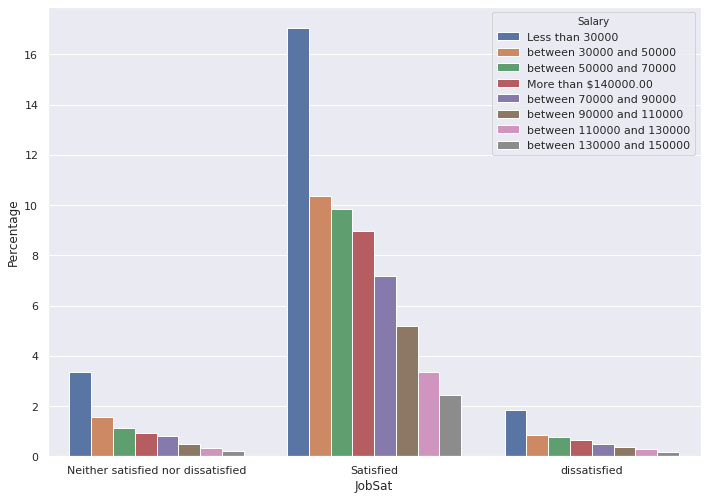

In [106]:
#We can see that most answers are satisfied and that salary is not predominant for satisfaction
#for we have almost all categories of wages more satisfied than not satisfied
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='JobSat',y='Percentage',data=dfSalaryJobsat, hue='Salary')

#### How does the satisfied respondent prefer to work?

In [0]:
JobSatWorkLoc = (100 * df.groupby('JobSat')['WorkLoc'].value_counts() / len(df.WorkLoc)).to_frame(name="Percentage").reset_index()

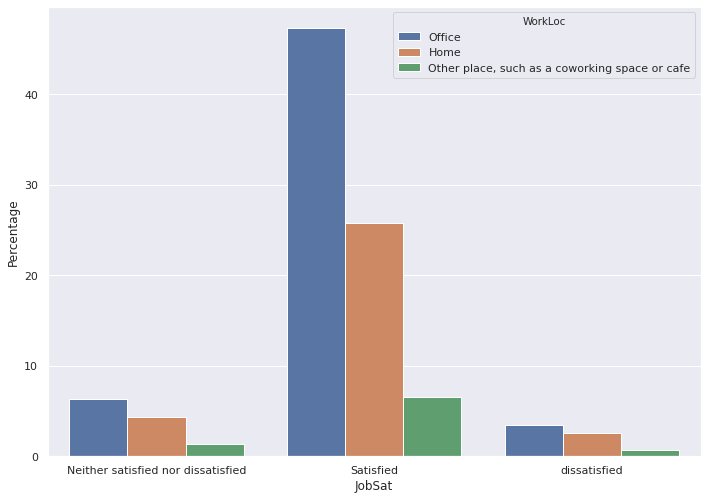

In [108]:
#Well, again we see that most people, satisfied or not, prefer to work in offices
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='JobSat',y='Percentage',data=JobSatWorkLoc, hue='WorkLoc')

#### Are people satisfied with the languages they have chosen?

In [0]:
dfDummies = df.set_index('Respondent')['LanguageWorkedWith'].str.get_dummies(';').reset_index()

In [0]:
result = pd.merge(dfDummies, 
                  df[['Respondent', 'JobSat']],
                  left_on='Respondent',
                  right_on='Respondent',
                  how='left')
result = result.set_index('Respondent')

In [0]:
columnNames = list(result.columns)

In [112]:
#Here we'll use a loop to count each language that the respondent is 
ds = pd.DataFrame()
for columnName in columnNames:
    result_columns = result.groupby('JobSat')[columnName].value_counts()
    result_columns = result_columns.drop(columns=columnName, axis=1)
    ds = pd.concat([ds, result_columns], axis=1)
ds = ds.reset_index()

#adjust the loop result 
indexDrop = ds[ ds['level_1'] != 1 ].index
ds.drop(indexDrop , inplace=True)
ds = ds.drop(columns=['level_1', 'JobSat'], axis=1)
ds = ds.rename(columns={"level_0": "JobSat"})
ds

,JobSat,Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,Other(s):,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly
1,Neither satisfied nor diss...,469.0,2923.0,1604.0,2760.0,1867.0,105.0,170.0,122.0,78.0,95.0,701.0,5415.0,3715.0,6019.0,608.0,465.0,722.0,2519.0,3234.0,440.0,662.0,223.0,4859.0,340.0,608.0,1972.0,535.0,83.0
3,Satisfied,2731.0,22157.0,9571.0,18276.0,11316.0,902.0,1019.0,888.0,519.0,641.0,5153.0,35995.0,21897.0,39797.0,3744.0,2961.0,5231.0,14308.0,22648.0,3199.0,5260.0,1721.0,32327.0,2399.0,3856.0,13627.0,3022.0,624.0
5,dissatisfied,229.0,1675.0,791.0,1526.0,954.0,74.0,88.0,87.0,55.0,58.0,377.0,2983.0,1890.0,3335.0,303.0,263.0,414.0,1287.0,1744.0,244.0,381.0,123.0,2706.0,203.0,314.0,1108.0,295.0,57.0


In [113]:
ds_transposed = ds.T
ds_transposed

,1,3,5
JobSat,Neither satisfied nor diss...,Satisfied,dissatisfied
Assembly,469,2731,229
Bash/Shell/PowerShell,2923,22157,1675
C,1604,9571,791
C#,2760,18276,1526
C++,1867,11316,954
Clojure,105,902,74
Dart,170,1019,88
Elixir,122,888,87
Erlang,78,519,55


In [114]:
ds = ds_transposed.rename(columns=ds_transposed.iloc[0]).drop(ds_transposed.index[0])
ds = ds.reset_index()
ds = ds.rename(columns={"index": "language"})
ds.head()

,language,Neither satisfied nor dissatisfied,Satisfied,dissatisfied
0,Assembly,469,2731,229
1,Bash/Shell/PowerShell,2923,22157,1675
2,C,1604,9571,791
3,C#,2760,18276,1526
4,C++,1867,11316,954


In [0]:
ds['Total'] = ds.iloc[:, 1:3].sum(axis=1)

In [116]:
ds['Satisfied'] = ds['Satisfied'] * 100 / ds['Total']
ds['Neither satisfied nor dissatisfied'] = ds['Neither satisfied nor dissatisfied'] * 100 / ds['Total']
ds['dissatisfied'] = ds['dissatisfied'] * 100 / ds['Total']
ds.head()

,language,Neither satisfied nor dissatisfied,Satisfied,dissatisfied,Total
0,Assembly,14.6562,85.3438,7.15625,3200.0
1,Bash/Shell/PowerShell,11.6547,88.3453,6.67863,25080.0
2,C,14.3535,85.6465,7.0783,11175.0
3,C#,13.1204,86.8796,7.25423,21036.0
4,C++,14.1622,85.8378,7.23659,13183.0


In the Charts below we can see that Clojure leads the list of those who are most satisfied according to the number of people who work with the language. And that Erlang is the one who has the most dissatisfied people and works with

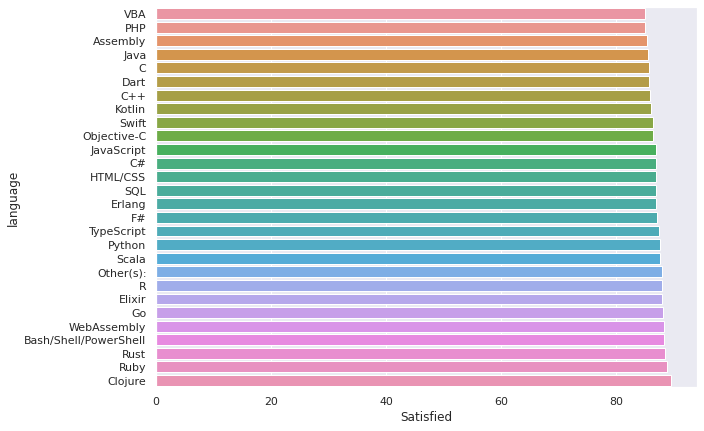

In [117]:
ds = ds.sort_values(by='Satisfied',ascending='True')
sns.set(rc={'figure.figsize':(9.7,7)})
sns.barplot(x='Satisfied',y='language',data=ds)

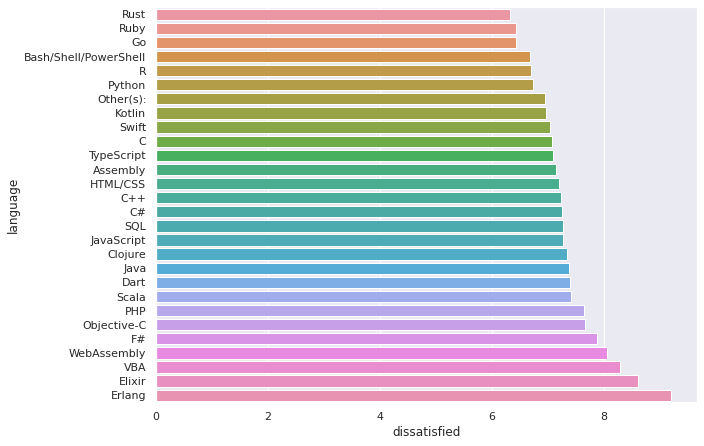

In [118]:
ds = ds.sort_values(by='dissatisfied',ascending='True')
sns.set(rc={'figure.figsize':(9.7,7.27)})
sns.barplot(x='dissatisfied',y='language',data=ds)

##2º question- What do the people who earn the most salaries have in common among the respondents?(education, orgSize)



In [0]:
Stack = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_public.csv')
Schema = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_schema.csv')

In [120]:
pd.set_option("display.max_columns", 15)
Stack.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,...,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is lear...,Yes,Never,The quality of OSS and clo...,"Not employed, and not look...",United Kingdom,...,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is lear...,No,Less than once per year,The quality of OSS and clo...,"Not employed, but looking ...",Bosnia and Herzegovina,...,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,I am not primarily a devel...,Yes,Never,The quality of OSS and clo...,Employed full-time,Thailand,...,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profes...,No,Never,The quality of OSS and clo...,Employed full-time,United States,...,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profes...,Yes,Once a month or more often,"OSS is, on average, of HIG...",Employed full-time,Ukraine,...,Man,No,Straight / Heterosexual,White or of European desce...,No,Appropriate in length,Easy


In [121]:
#Generating a dataset with the average salary according to the size of the company
StackSalarybid = pd.DataFrame()
StackSalarybid = Stack.groupby('OrgSize').mean().ConvertedComp.sort_values(ascending=False).to_frame(name = 'Salary').reset_index()
StackSalarybid.loc[[5],"OrgSize"] = 'Freelancer'
StackSalarybid = StackSalarybid.round(2)
StackSalarybid

,OrgSize,Salary
0,"10,000 or more employees",175389.06
1,"5,000 to 9,999 employees",157500.94
2,"1,000 to 4,999 employees",143154.72
3,500 to 999 employees,128330.77
4,100 to 499 employees,127505.80
5,Freelancer,113136.93
6,20 to 99 employees,113087.82
7,2-9 employees,96194.10
8,10 to 19 employees,93326.65


In [0]:
Stack.ConvertedComp = Stack.ConvertedComp.round(2)

In [0]:
#Generating a dataset with the average salary according to the degree of training of the respondents
StackEdBid = Stack.groupby('EdLevel').mean().ConvertedComp.sort_values(ascending=False).to_frame(name = 'Salary').reset_index()
StackEdBid = StackEdBid.round(2)

In [124]:
StackEdBid

,EdLevel,Salary
0,Other doctoral degree (Ph....,171504.38
1,I never completed any form...,154087.31
2,Associate degree,146191.28
3,"Bachelor’s degree (BA, BS,...",134966.13
4,"Master’s degree (MA, MS, M...",120712.39
5,Some college/university st...,117587.73
6,Primary/elementary school,95072.55
7,"Professional degree (JD, M...",86490.19
8,Secondary school (e.g. Ame...,85330.02


In [125]:
#Creating a dataframe with the number of respondents by degree of training
EdLevelCounts = pd.DataFrame()
EdLevelCounts = Stack['EdLevel'].value_counts().sort_values(ascending=False).to_frame(name = 'count').reset_index()
EdLevelCounts.columns = ['EdLevel','respondents']
EdLevelCounts

,EdLevel,respondents
0,"Bachelor’s degree (BA, BS,...",39134
1,"Master’s degree (MA, MS, M...",19569
2,Some college/university st...,10502
3,Secondary school (e.g. Ame...,8642
4,Associate degree,2938
5,Other doctoral degree (Ph....,2432
6,Primary/elementary school,1422
7,"Professional degree (JD, M...",1198
8,I never completed any form...,553


In [0]:
#reindex datasets
EdLevelCounts = EdLevelCounts.reindex(sorted(EdLevelCounts.columns), axis=1)
StackEdBid = StackEdBid.reindex(sorted(StackEdBid.columns), axis=1)

In [127]:
#Merging
result = pd.merge(EdLevelCounts, StackEdBid, how='left')
result

,EdLevel,respondents,Salary
0,"Bachelor’s degree (BA, BS,...",39134,134966.13
1,"Master’s degree (MA, MS, M...",19569,120712.39
2,Some college/university st...,10502,117587.73
3,Secondary school (e.g. Ame...,8642,85330.02
4,Associate degree,2938,146191.28
5,Other doctoral degree (Ph....,2432,171504.38
6,Primary/elementary school,1422,95072.55
7,"Professional degree (JD, M...",1198,86490.19
8,I never completed any form...,553,154087.31


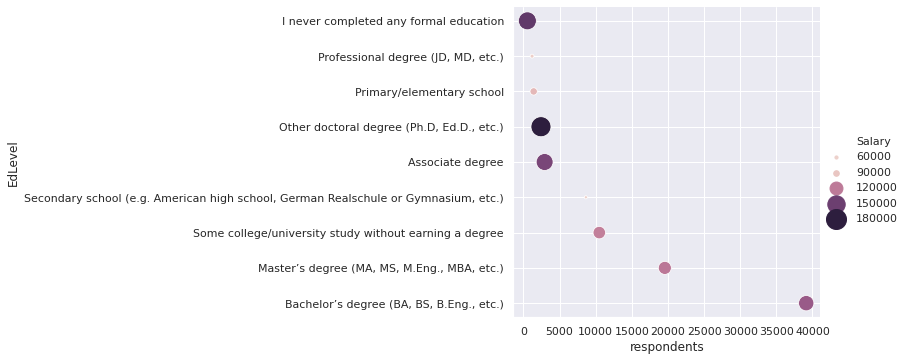

In [128]:
#Plot showing salary, by level of education and the number of people within that salary
sns.relplot(x="respondents", 
            y="EdLevel", 
            hue="Salary", 
            data=result, 
            size="Salary", 
            sizes=(10, 400));

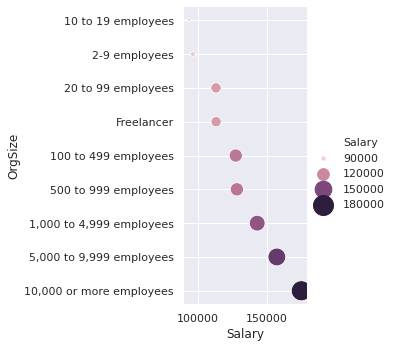

In [129]:
#Plot showing salary, by company size and the number of people within that salary
sns.relplot(x="Salary", 
            y="OrgSize", 
            hue="Salary", 
            data=StackSalarybid, 
            size="Salary",
            sizes=(10, 400));

## 3º Question: Can we predict what is necessary to join a big company?

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from string import ascii_letters
from collections import defaultdict, Counter
%matplotlib inline 
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.use_inf_as_na = True
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_colwidth", 30)   

In [0]:
Stack = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_public.csv')
Schema = pd.read_csv('/content/drive/My Drive/Data Science Udacity/stackoverflow_dataset/survey_results_schema.csv')

In [132]:
Stack.dropna(subset = ["OrgSize"], inplace=True)
print(Stack.shape)

(71791, 85)


In [133]:
Stack['OrgSize'].isnull().sum()

0

In [134]:
#print(df2.head())
searchfor = ['hobby', 'longer']
Stack = Stack[~Stack.MainBranch.str.contains('|'.join(searchfor), na=False)]
print(Stack.MainBranch.value_counts())

I am a developer by profession                                                   62268
I am not primarily a developer, but I write code sometimes as part of my work     6847
Name: MainBranch, dtype: int64


In [0]:
df = Stack[['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment', 'Student', 
            'EdLevel', 'UndergradMajor', 'EduOther', 'LastHireDate', 'LanguageWorkedWith', 
            'DatabaseWorkedWith', 'WebFrameWorkedWith', 'MiscTechWorkedWith', 'Age', 'Country', 'ConvertedComp', 'OrgSize']]

df = df.fillna(df.mode().iloc[0])


In [0]:
df2 = df.set_index('Respondent')['EduOther'].str.get_dummies(';')
df3 = df.set_index('Respondent')['LanguageWorkedWith'].str.get_dummies(';')
df4 = df.set_index('Respondent')['DatabaseWorkedWith'].str.get_dummies(';')
df5 = df.set_index('Respondent')['WebFrameWorkedWith'].str.get_dummies(';')
df6 = df.set_index('Respondent')['MiscTechWorkedWith'].str.get_dummies(';')
dfs = [df, df2, df3, df4, df5, df6]

In [137]:
import functools
df = df.set_index('Respondent')
df.head(1)

,MainBranch,Hobbyist,OpenSourcer,Employment,Student,EdLevel,UndergradMajor,EduOther,LastHireDate,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,MiscTechWorkedWith,Age,Country,ConvertedComp,OrgSize
Respondent,,,,,,,,,,,,,,,,,
3,I am not primarily a devel...,Yes,Never,Employed full-time,No,"Bachelor’s degree (BA, BS,...",Web development or web design,Taught yourself a new lang...,1-2 years ago,HTML/CSS,PostgreSQL,jQuery,Node.js,28.0,Thailand,8820.0,100 to 499 employees


In [138]:
#df = df.set_index('Respondent')
df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='Respondent'), dfs)
df_final.head(3)

,Respondent,MainBranch,Hobbyist,OpenSourcer,Employment,Student,EdLevel,UndergradMajor,EduOther,LastHireDate,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,MiscTechWorkedWith,Age,Country,ConvertedComp,OrgSize,Completed an industry certification program (e.g. MCPD),Contributed to open source software,Participated in a full-time developer training program or bootcamp,Participated in a hackathon,"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)",Received on-the-job training in software development,Taken a part-time in-person course in programming or software development,Taken an online course in programming or software development (e.g. a MOOC),"Taught yourself a new language, framework, or tool without taking a formal course",Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,Other(s):_x,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly,Cassandra,Couchbase,DynamoDB,Elasticsearch,Firebase,MariaDB,Microsoft SQL Server,MongoDB,MySQL,Oracle,Other(s):_y,PostgreSQL,Redis,SQLite,ASP.NET,Angular/Angular.js,Django,Drupal,Express,Flask,Laravel,Other(s):_x,React.js,Ruby on Rails,Spring,Vue.js,jQuery,.NET,.NET Core,Ansible,Apache Spark,Chef,Cordova,CryEngine,Flutter,Hadoop,Node.js,Other(s):_y,Pandas,Puppet,React Native,TensorFlow,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
0,3,I am not primarily a devel...,Yes,Never,Employed full-time,No,"Bachelor’s degree (BA, BS,...",Web development or web design,Taught yourself a new lang...,1-2 years ago,HTML/CSS,PostgreSQL,jQuery,Node.js,28.0,Thailand,8820.0,100 to 499 employees,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,4,I am a developer by profes...,No,Never,Employed full-time,No,"Bachelor’s degree (BA, BS,...","Computer science, computer...",Taken an online course in ...,Less than a year ago,C;C++;C#;Python;SQL,MySQL;SQLite,jQuery,.NET,22.0,United States,61000.0,100 to 499 employees,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,I am a developer by profes...,Yes,Once a month or more often,Employed full-time,No,"Bachelor’s degree (BA, BS,...","Computer science, computer...",Taken an online course in ...,Less than a year ago,C++;HTML/CSS;Java;JavaScri...,Couchbase;MongoDB;MySQL;Or...,Django;Express;Flask;jQuer...,Cordova;Node.js,30.0,Ukraine,2000000.0,"10,000 or more employees",0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [139]:
df = df_final.set_index('Respondent')
df.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Student,EdLevel,UndergradMajor,EduOther,LastHireDate,LanguageWorkedWith,DatabaseWorkedWith,WebFrameWorkedWith,MiscTechWorkedWith,Age,Country,ConvertedComp,OrgSize,Completed an industry certification program (e.g. MCPD),Contributed to open source software,Participated in a full-time developer training program or bootcamp,Participated in a hackathon,"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)",Received on-the-job training in software development,Taken a part-time in-person course in programming or software development,Taken an online course in programming or software development (e.g. a MOOC),"Taught yourself a new language, framework, or tool without taking a formal course",Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,Other(s):_x,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly,Cassandra,Couchbase,DynamoDB,Elasticsearch,Firebase,MariaDB,Microsoft SQL Server,MongoDB,MySQL,Oracle,Other(s):_y,PostgreSQL,Redis,SQLite,ASP.NET,Angular/Angular.js,Django,Drupal,Express,Flask,Laravel,Other(s):_x,React.js,Ruby on Rails,Spring,Vue.js,jQuery,.NET,.NET Core,Ansible,Apache Spark,Chef,Cordova,CryEngine,Flutter,Hadoop,Node.js,Other(s):_y,Pandas,Puppet,React Native,TensorFlow,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
Respondent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,I am not primarily a devel...,Yes,Never,Employed full-time,No,"Bachelor’s degree (BA, BS,...",Web development or web design,Taught yourself a new lang...,1-2 years ago,HTML/CSS,PostgreSQL,jQuery,Node.js,28.0,Thailand,8820.0,100 to 499 employees,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,I am a developer by profes...,No,Never,Employed full-time,No,"Bachelor’s degree (BA, BS,...","Computer science, computer...",Taken an online course in ...,Less than a year ago,C;C++;C#;Python;SQL,MySQL;SQLite,jQuery,.NET,22.0,United States,61000.0,100 to 499 employees,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,I am a developer by profes...,Yes,Once a month or more often,Employed full-time,No,"Bachelor’s degree (BA, BS,...","Computer science, computer...",Taken an online course in ...,Less than a year ago,C++;HTML/CSS;Java;JavaScri...,Couchbase;MongoDB;MySQL;Or...,Django;Express;Flask;jQuer...,Cordova;Node.js,30.0,Ukraine,2000000.0,"10,000 or more employees",0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,I am a developer by profes...,No,Never,"Independent contractor, fr...",No,"Bachelor’s degree (BA, BS,...",Another engineering discip...,Taught yourself a new lang...,NA - I am an independent c...,HTML/CSS;JavaScript,Microsoft SQL Server,React.js,Node.js,42.0,Ukraine,2000000.0,Just me - I am a freelance...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,I am a developer by profes...,Yes,Once a month or more often,Employed full-time,No,Some college/university st...,"Computer science, computer...",Taken an online course in ...,Less than a year ago,Bash/Shell/PowerShell;C#;H...,DynamoDB;PostgreSQL;SQLite,Express;Ruby on Rails;Othe...,Node.js;Unity 3D,23.0,New Zealand,95179.0,10 to 19 employees,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [140]:
df.isnull().sum(axis = 0)

MainBranch       0
Hobbyist         0
OpenSourcer      0
Employment       0
Student          0
                ..
TensorFlow       0
Torch/PyTorch    0
Unity 3D         0
Unreal Engine    0
Xamarin          0
Length: 100, dtype: int64

In [141]:
df.dtypes.head(5)

MainBranch     object
Hobbyist       object
OpenSourcer    object
Employment     object
Student        object
dtype: object

In [142]:
for column in df:
    try:
      if df[column].dtypes == 'object':
        df[column] = df[column].astype("category")
    except:
      pass 
df.dtypes

MainBranch       category
Hobbyist         category
OpenSourcer      category
Employment       category
Student          category
                   ...   
TensorFlow          int64
Torch/PyTorch       int64
Unity 3D            int64
Unreal Engine       int64
Xamarin             int64
Length: 100, dtype: object

In [0]:
for column in df:
    try:
      if df[column].dtype != 'int64' and df[column].dtype != 'float64':
        df[column] = df[column].cat.codes
    # block raising an exception
    except:
      pass # doing nothing on exception

In [144]:
df = df.drop(['EduOther','LanguageWorkedWith','DatabaseWorkedWith','WebFrameWorkedWith','MiscTechWorkedWith'], axis=1)
df.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Student,EdLevel,UndergradMajor,LastHireDate,Age,Country,ConvertedComp,OrgSize,Completed an industry certification program (e.g. MCPD),Contributed to open source software,Participated in a full-time developer training program or bootcamp,Participated in a hackathon,"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)",Received on-the-job training in software development,Taken a part-time in-person course in programming or software development,Taken an online course in programming or software development (e.g. a MOOC),"Taught yourself a new language, framework, or tool without taking a formal course",Assembly,Bash/Shell/PowerShell,C,C#,C++,Clojure,Dart,Elixir,Erlang,F#,Go,HTML/CSS,Java,JavaScript,Kotlin,Objective-C,Other(s):_x,PHP,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA,WebAssembly,Cassandra,Couchbase,DynamoDB,Elasticsearch,Firebase,MariaDB,Microsoft SQL Server,MongoDB,MySQL,Oracle,Other(s):_y,PostgreSQL,Redis,SQLite,ASP.NET,Angular/Angular.js,Django,Drupal,Express,Flask,Laravel,Other(s):_x,React.js,Ruby on Rails,Spring,Vue.js,jQuery,.NET,.NET Core,Ansible,Apache Spark,Chef,Cordova,CryEngine,Flutter,Hadoop,Node.js,Other(s):_y,Pandas,Puppet,React Native,TensorFlow,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
Respondent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1,1,2,0,0,1,11,0,28.0,148,8820.0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,1,6,3,22.0,161,61000.0,3,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,3,0,0,1,6,3,30.0,157,2000000.0,2,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,2,2,0,1,5,5,42.0,157,2000000.0,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,0,1,3,0,0,8,6,3,23.0,107,95179.0,1,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [0]:
X_train_original = df.drop(['OrgSize'], axis=1)
y_train_original = Stack[['Respondent', 'OrgSize']].set_index('Respondent')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train_original, y_train_original, test_size=0.30, random_state=42)

In [147]:
print(X_train.shape)
print( X_test.shape)
print(y_train.shape)
print(y_test.shape)

(48524, 94)
(20797, 94)
(48524, 1)
(20797, 1)


In [148]:
#https://www.datacamp.com/community/tutorials/decision-tree-classification-python
from sklearn import metrics
# Create Decision Tree classifer object
#clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf=RandomForestClassifier(n_estimators=100)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2915805164206376
